# Latent Net implementation

>> Notes to the new implementation - debugging


>> - the implementation of the Fourier features is wrong. get back to that later
>> - make sure that the train function loops over the parameters that are part  of the train set (i.e. the alphas that define the training sims)
>> - the append operation
>> - plot the latent state
>> - remove the train_snaphots and test_snapshots variables
>> - for each parameter, I train always on the same positions. to be changed?

>> using more batches does not work

>> - using 1 batch of 5000 points produces interesting results. (backward ext)
>> - using 1 batch of 7e3 points learns nice on small dataset (1000 epochs, backward ext)


>> - LBFGS
>> - enlarge the networks
>> - try with 90 percent of train dataset 

In [1]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

#torch.set_default_dtype(torch.float32)

In [2]:
# Install PyG
try:
  import torch_geometric
except ImportError:
  !pip3 install torch_geometric
  import torch_geometric

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Import some utils from gca-rom
import sys
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/Fra-Sala/gnn_time.git
    sys.path.append('gnn_time')
else:
    sys.path.append('./..')
    
from latent_net import dynamics_network, initialization, loader, preprocessing_scale, train, plotting, testing

In [5]:
variable = 'U'
problem_name = 'lid_cavity'
print("\nProblem: ", problem_name)
print("Variable: ", variable)



Problem:  lid_cavity
Variable:  U


## Set training parameters

In [6]:
train_rate = 50 # percentage of data used for training
dim_latent = 10
epochs = 300
step_integration = 1e-1   # time step forward euler
pos_per_batch = 15681 
num_batches = 1
# scaling_type = 2 
# scaler_number = 3
final_time_simulation = 2.0 # do not change even if you consider less snapshots (shorter simulations)
argv = [problem_name, variable, train_rate, dim_latent, step_integration, epochs, pos_per_batch, num_batches, final_time_simulation]
HyperParams = dynamics_network.HyperParams(argv)

# Initialization

In [7]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)

Device used:  cpu


# Load dataset

In [8]:
if 'google.colab' in str(get_ipython()):
    dataset_dir = '/content/gnn_time/dataset/'+problem_name+'_unstructured.mat'
else:
    dataset_dir = '../dataset/'+problem_name+'_unstructured.mat'

# Import the data from the mat file  and get rid of the initial condition for each simulation
dataset = loader.LoadDataset(dataset_dir, variable)
dataset.U = np.delete(dataset.U, np.s_[::10], 1)



# Take first 3 snaps for two simulations
#cols_to_delete = list(range(3, 9)) +  list(range(12, dataset.U.shape[1]))
# 
#cols_to_delete = list(range(3, 9)) + list(range(12, 18)) + list(range(21, 27)) + list(range(30, dataset.U.shape[1]))
# 
#cols_to_delete = list(range(0, 9)) + list(range(11, 18)) + list(range(20, 27)) + list(range(29, 36)) + list(range(38, dataset.U.shape[1]))
#cols_to_delete = list(range(36, dataset.U.shape[1]))
#dataset.U = np.delete(dataset.U, cols_to_delete, 1)


### DEBUG: take only the first two snapshots

#dataset.U = np.delete(dataset.U,np.s_[4:],1 )

In [9]:
# if 'google.colab' in str(get_ipython()):
#     u_t_latent = np.load('/content/gnn_time/lid_driven_cavity_fenics/u_t_latent.npy')
# else:
#     u_t_latent = np.load('../lid_driven_cavity_fenics/u_t_latent.npy')

# Import the single Fourier mode
if 'google.colab' in str(get_ipython()):
    params = np.load('/content/gnn_time/lid_driven_cavity_fenics/alpha1.npy')
else:
    params = np.load('../lid_driven_cavity_fenics/alpha1.npy')

############ TAKE ONLY THE FIRST two PARAMETER (FOURIER COEFF) #############
#params = params[:4]
time = np.linspace(0.0, 1.8, 10)


# Get rid of the initial condition evaluation (0.0)
# u_t_latent = np.delete(u_t_latent, np.s_[::10], 0)   
# u_t_tensor = torch.from_numpy(u_t_latent)
time_tensor = torch.from_numpy(time)
print("Number of simulations (series of snaps):", len(params))
print("Number of instants of time (initial time excluded):", len(time)-1)

#alpha1_vec = alpha1_vec.reshape(-1,1)


Number of simulations (series of snaps): 20
Number of instants of time (initial time excluded): 9


In [10]:
train_loader, test_loader, scaler_all,\
scaler_test, VAR_all, VAR_test, train_snapshots,\
test_snapshots, position_dataset, params_train, params_test = preprocessing_scale.process_and_scale_dataset(dataset, HyperParams, params)

Number of nodes processed:  15681
Number of simulations processed:  20


In [11]:
# data_test_iterator = iter(test_loader)
# data_test = next(data_test_iterator).to(device)
# data_test[:, :, 0]

## This should be followed to scale back the data


# alpha0, alphaw = scaler_all[0], scaler_all[1]
# scaled_back_test = preprocessing_scale.inverse_normalize_input(data_test, alpha0, alphaw, np.arange(18,36,1))
# print("Scaled back trian or test dataset")
# scaled_back_test[:, 0:20, 0]


# Define the architecture

In [12]:
# The dynamics net takes u(t) as input and s(t)
dyn_input_size = 1 + HyperParams.dim_latent
dyn_hidden_size = 20
dim = 2 # we are in 2D

#rec_input_size = dim*HyperParams.rff_encoded_mult*HyperParams.batch_pos_size + HyperParams.dim_latent
rec_input_size = dim*HyperParams.batch_pos_size + HyperParams.dim_latent
rec_hidden_size = dyn_hidden_size
rec_output_size = HyperParams.batch_pos_size

dyn_model = dynamics_network.DynNet(dyn_input_size, dyn_hidden_size, HyperParams.dim_latent)
rec_model = dynamics_network.RecNet(rec_input_size, rec_hidden_size, rec_output_size)
dyn_model = dyn_model.to(device)
rec_model = rec_model.to(device)

torch.set_default_dtype(torch.float32)
optimizer = torch.optim.Adam([
    {'params': dyn_model.parameters()},
    {'params': rec_model.parameters()}
], lr=HyperParams.learning_rate,  weight_decay=HyperParams.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

# Train the network

In [13]:
try:
    dyn_model.load_state_dict(torch.load(HyperParams.net_dir + HyperParams.net_name + '_dyn.pt'))
    rec_model.load_state_dict(torch.load(HyperParams.net_dir + HyperParams.net_name + '_rec.pt'))
    print('Loading saved network')
except:
    print('No saved network found')
    train_history, test_history = train.train_dyn_rec_nets(dyn_model, rec_model, optimizer, scheduler,\
                          device, params_train, params_test, time_tensor, train_loader, test_loader, position_dataset,\
                              train_snapshots, test_snapshots, HyperParams)
    plt.figure()
    plt.semilogy(train_history['loss'], label='train loss')
    plt.semilogy(test_history['loss'], label='test loss')
    plt.legend()
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(HyperParams.net_dir+'loss_train_test.png', bbox_inches='tight', dpi=500)

Loading saved network


# Test the model over the test set

In [14]:
from latent_net import plotting, testing
PARAMS = np.repeat(params, len(time)-1, axis=0)
TIMES = np.tile(time[1:], params.shape[0])
# concatenate TIMES and params_test as two columns
#np.random.shuffle(test_snapshots)
snapshots = train_snapshots[-2:]


# the rescaling is correct, and the predictions are qualitatively correct
#rescaled_results = preprocessing_scale.inverse_normalize_input(results, scaler_all, snapshots)




# Plot the results

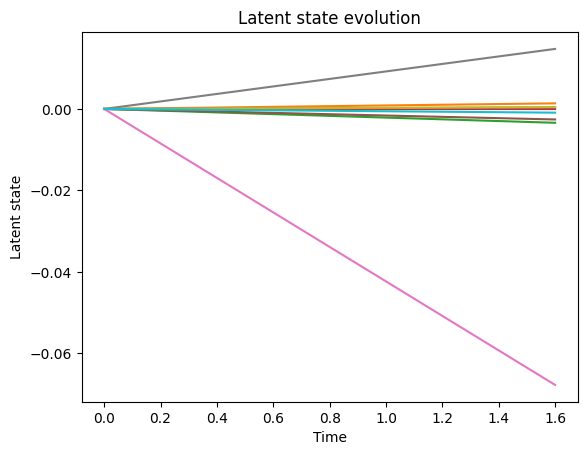

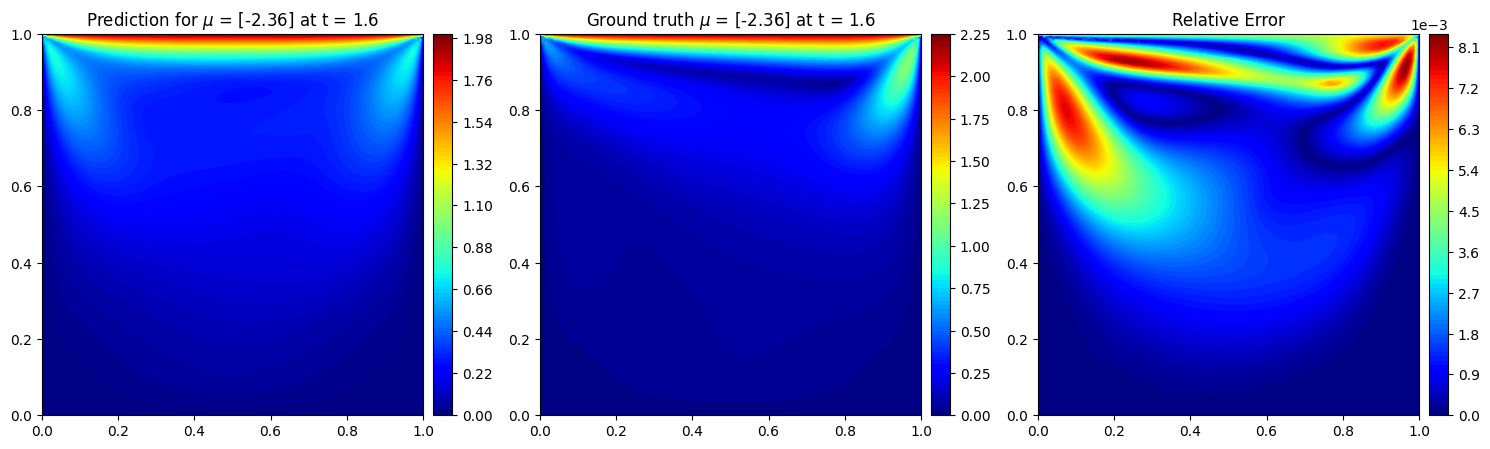

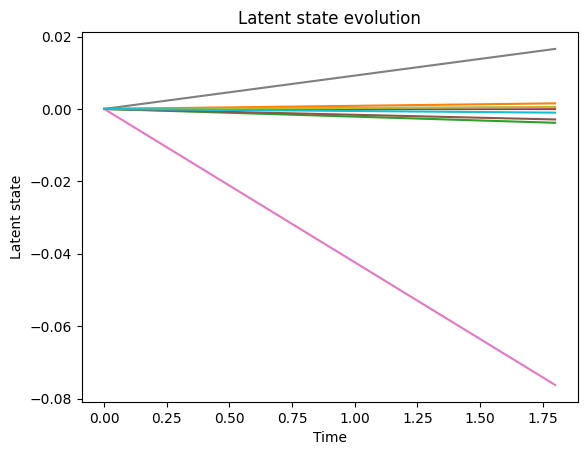

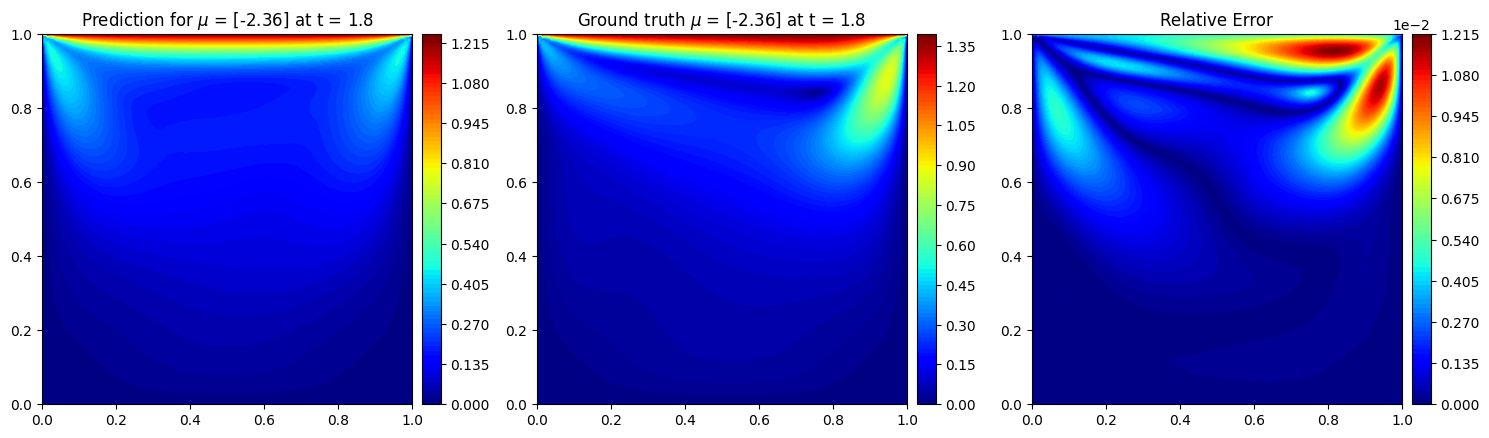

In [15]:
num_iterations = len(position_dataset)//HyperParams.batch_pos_size
for i,SNAP in enumerate(snapshots):
    for j in range(num_iterations):
        pos_test = position_dataset[j*HyperParams.batch_pos_size:(j+1)*HyperParams.batch_pos_size:]
        results, stn_evolution, time_evolution = testing.test(dyn_model, rec_model, device, PARAMS[SNAP], TIMES[SNAP], pos_test, HyperParams)
        if j == 0:
            result = results
        else:
            result = torch.cat((result, results), dim=0)
    plotting.plot_latent(stn_evolution, time_evolution)
    
    if len(position_dataset) - len(result) > 0:
        result = torch.cat((result, torch.zeros(len(position_dataset) - len(result))), dim=0)

    result = result.unsqueeze(0).unsqueeze(2)
    #print(result[0, 0:20, 0])
    #print("the snapshot is: ", SNAP)
    plotting.plot_fields(SNAP, result, scaler_all, HyperParams, dataset, position_dataset, PARAMS, TIMES)
    i+1